<a href="https://colab.research.google.com/github/lcipolina/art/blob/main/prompts/clip_interrogator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Interrogator by [@pharmapsychotic](https://twitter.com/pharmapsychotic) 

<br>

What do the different OpenAI CLIP models see in an image? What might be a good text prompt to create similar images using CLIP guided diffusion or another text to image model? The CLIP Interrogator is here to get you answers!

<br>

The CLIP Interrogator uses the OpenAI CLIP models to test a given image against a variety of artists, mediums, and styles to study how the different models see the content of the image. It also combines the results with BLIP caption to suggest a text prompt to create more images similar to what was given.

<br>

And if you're looking for more Ai art tools check out my [Ai generative art tools list](https://pharmapsychotic.com/tools.html).



Code rationale is explained here

https://twitter.com/pharmapsychotic/status/1557023866404458498?s=20&t=0fDMRDXgHmFo3klqSTaalA
Some explanations:

"I use CLIP as classifier ranking the different artists and terms to see which each CLIP model is most confident of and combining the results.

Dataset: so far 4,760 artists, 274 flavors, 190 art movements, 88 mediums"


In [1]:
#@title Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9f96024b-4d24-a151-2a8b-59158c6325e7)


In [6]:
#@title Setup
!pip3 install ftfy regex tqdm transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
!pip3 install git+https://github.com/openai/CLIP.git
!git clone https://github.com/pharmapsychotic/clip-interrogator.git
!git clone https://github.com/salesforce/BLIP
%cd /content/BLIP

import clip
import gc
import numpy as np
import os
import pandas as pd
import requests
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from IPython.display import display
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from models.blip import blip_decoder

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

blip_image_eval_size = 384
blip_model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth'        
blip_model = blip_decoder(pretrained=blip_model_url, image_size=blip_image_eval_size, vit='base')
blip_model.eval()
blip_model = blip_model.to(device)

def generate_caption(pil_image):
    '''
    Takes-in an image and generates a caption calling OpenAI's BLIP
    Used by "interrogate"
    '''
    gpu_image = transforms.Compose([
        transforms.Resize((blip_image_eval_size, blip_image_eval_size), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])(image).unsqueeze(0).to(device)

    with torch.no_grad():
        caption = blip_model.generate(gpu_image, sample=False, num_beams=3, max_length=20, min_length=5)
    return caption[0]

def load_list(filename):
    with open(filename, 'r', encoding='utf-8', errors='replace') as f:
        items = [line.strip() for line in f.readlines()]
    return items

def rank(model, image_features, text_array, top_count=1):
    '''
    Similarity between img features and text
    The img features comes from a ViT model and the text comes from BLIP
    :input text array: medium, artists, movement, etc
    '''
    top_count = min(top_count, len(text_array))
    text_tokens = clip.tokenize([text for text in text_array]).cuda()
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # calculates similarity between image featuers and text features
    # It is doing the correlation (i.e. matrix multiplication) by hand
    similarity = torch.zeros((1, len(text_array))).to(device)
    for i in range(image_features.shape[0]):
        similarity += (100.0 * image_features[i].unsqueeze(0) @ text_features.T).softmax(dim=-1)
    similarity /= image_features.shape[0]

    #gets the features and texts with highest correl coef 
    top_probs, top_labels = similarity.cpu().topk(top_count, dim=-1)  
    return [(text_array[top_labels[0][i].numpy()], (top_probs[0][i].numpy()*100)) for i in range(top_count)]

def interrogate(image, models):
    '''
    Main driver
    '''
    #Generate a caption for the input image with BLIP
    caption = generate_caption(image)
    if len(models) == 0:
        print(f"\n\n{caption}")
        return

    #Calls selected ViT model to extract features and ranks
    table = []
    bests = [[('',0)]]*5
    for model_name in models:
        print(f"Interrogating with {model_name}...")
        model, preprocess = clip.load(model_name)
        model.cuda().eval()

        images = preprocess(image).unsqueeze(0).cuda()
        with torch.no_grad():
            image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)

        #Calls 'rank' function to get the highest ranked (img feature, text) in terms of higher correl
        ranks = [
            rank(model, image_features, mediums),
            rank(model, image_features, ["by "+artist for artist in artists]),
            rank(model, image_features, trending_list),
            rank(model, image_features, movements),
            rank(model, image_features, flavors, top_count=3)
        ]

        for i in range(len(ranks)):
            confidence_sum = 0
            for ci in range(len(ranks[i])):
                confidence_sum += ranks[i][ci][1]
            if confidence_sum > sum(bests[i][t][1] for t in range(len(bests[i]))):
                bests[i] = ranks[i]

        row = [model_name]
        for r in ranks:
            row.append(', '.join([f"{x[0]} ({x[1]:0.1f}%)" for x in r]))

        table.append(row)

        del model
        gc.collect()
    display(pd.DataFrame(table, columns=["Model", "Medium", "Artist", "Trending", "Movement", "Flavors"]))

    flaves = ', '.join([f"{x[0]}" for x in bests[4]])
    medium = bests[0][0][0]
    if caption.startswith(medium):
        print(f"\n\n{caption} {bests[1][0][0]}, {bests[2][0][0]}, {bests[3][0][0]}, {flaves}")
    else:
        print(f"\n\n{caption}, {medium} {bests[1][0][0]}, {bests[2][0][0]}, {bests[3][0][0]}, {flaves}")

data_path = "../clip-interrogator/data/"

artists = load_list(os.path.join(data_path, 'artists.txt'))
flavors = load_list(os.path.join(data_path, 'flavors.txt'))
mediums = load_list(os.path.join(data_path, 'mediums.txt'))
movements = load_list(os.path.join(data_path, 'movements.txt'))

sites = ['Artstation', 'behance', 'cg society', 'cgsociety', 'deviantart', 'dribble', 'flickr', 'instagram', 'pexels', 'pinterest', 'pixabay', 'pixiv', 'polycount', 'reddit', 'shutterstock', 'tumblr', 'unsplash', 'zbrush central']
trending_list = [site for site in sites]
trending_list.extend(["trending on "+site for site in sites])
trending_list.extend(["featured on "+site for site in sites])
trending_list.extend([site+" contest winner" for site in sites])


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-gb9l33i_
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-gb9l33i_
Cloning into 'clip-interrogator'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 67 (delta 6), reused 6 (delta 6), pack-reused 57
Unpacking objects: 100% (67/67), done.
Cloning into 'BLIP'...
remote: Enumerating objects: 268, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 268 (delta 143), reused 245 (delta 137), pack-reused 0
Receiving objects: 100% (268/268), 7.66 MiB | 26.25 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/BLIP
load checkpo

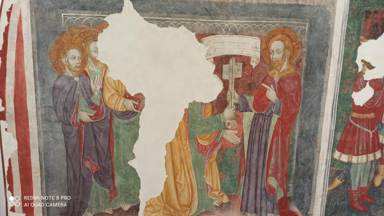

Interrogating with ViT-B/32...


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 63.5MiB/s]


Interrogating with ViT-B/16...


100%|███████████████████████████████████████| 335M/335M [00:05<00:00, 69.7MiB/s]


Interrogating with RN50...


100%|████████████████████████████████████████| 244M/244M [00:01<00:00, 175MiB/s]


,Model,Medium,Artist,Trending,Movement,Flavors
0,ViT-B/32,a detailed painting (48.9%),by Quirizio di Giovanni da Murano (12.3%),polycount (17.6%),qajar art (12.2%),"fresco (85.5%), detailed painting (3.8%), high..."
1,ViT-B/16,an ultrafine detailed painting (62.5%),by Pietro Lorenzetti (14.9%),featured on instagram (7.6%),romanesque (52.1%),"fresco (92.7%), detailed painting (3.3%), stai..."
2,RN50,a mosaic (38.6%),by Luca della Robbia (15.6%),tumblr contest winner (14.4%),romanesque (25.6%),"fresco (97.6%), flemish baroque (0.4%), renais..."




a painting of a group of people in a room, an ultrafine detailed painting by Luca della Robbia, polycount, romanesque, fresco, flemish baroque, renaissance painting


In [5]:
#@title Interrogate!

#@markdown 

#@markdown #####**Image:**

image_path_or_url = "https://github.com/lcipolina/art/blob/main/img/conegliano_missing_person.jpeg?raw=true" #@param {type:"string"}

#@markdown 

#@markdown #####**CLIP models:**

#@markdown For [StableDiffusion](https://stability.ai/blog/stable-diffusion-announcement) you can just use ViTL14<br>
#@markdown For [DiscoDiffusion](https://colab.research.google.com/github/alembics/disco-diffusion/blob/main/Disco_Diffusion.ipynb) and 
#@markdown [JAX](https://colab.research.google.com/github/huemin-art/jax-guided-diffusion/blob/v2.7/Huemin_Jax_Diffusion_2_7.ipynb) enable all the same models here as you intend to use when generating your images

ViTB32 = True #@param{type:"boolean"}
ViTB16 = True #@param{type:"boolean"}
ViTL14 = False #@param{type:"boolean"}
ViTL14_336px = False #@param{type:"boolean"}
RN101 = False #@param{type:"boolean"}
RN50 = True #@param{type:"boolean"}
RN50x4 = False #@param{type:"boolean"}
RN50x16 = False #@param{type:"boolean"}
RN50x64 = False #@param{type:"boolean"}

models = []
if ViTB32: models.append('ViT-B/32')
if ViTB16: models.append('ViT-B/16')
if ViTL14: models.append('ViT-L/14')
if ViTL14_336px: models.append('ViT-L/14@336px')
if RN101: models.append('RN101')
if RN50: models.append('RN50')
if RN50x4: models.append('RN50x4')
if RN50x16: models.append('RN50x16')
if RN50x64: models.append('RN50x64')

if str(image_path_or_url).startswith('http://') or str(image_path_or_url).startswith('https://'):
    image = Image.open(requests.get(image_path_or_url, stream=True).raw).convert('RGB')
else:
    image = Image.open(image_path_or_url).convert('RGB')

thumb = image.copy()
thumb.thumbnail([blip_image_eval_size, blip_image_eval_size])
display(thumb)

interrogate(image, models=models)
